In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
data = pd.read_csv("C:/Users/sanke/OneDrive/Desktop/email_classification.csv")
data.head()


,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


In [9]:
data.shape


(179, 2)

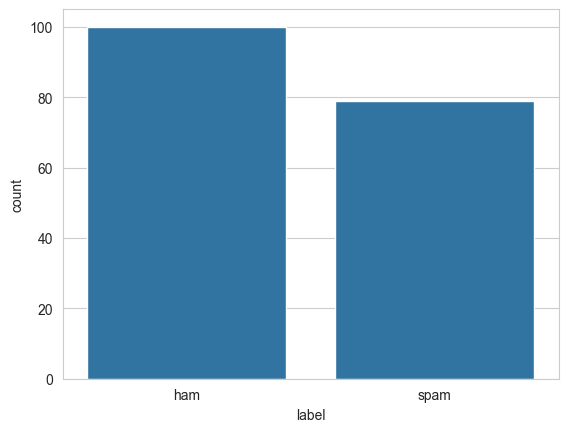

In [12]:
sns.countplot(x='label', data=data)
plt.show()


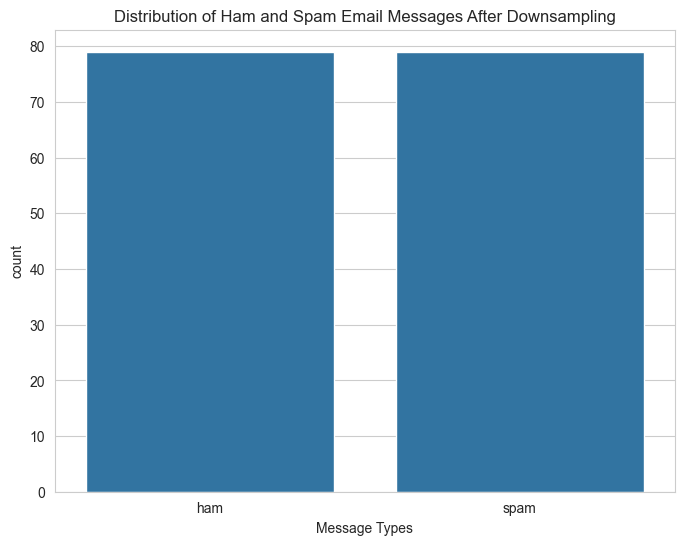

In [15]:
# Downsampling to balance the dataset
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample ham messages to match the number of spam messages
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine the downsampled ham messages and spam messages
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)

# Plotting the counts of the downsampled dataset
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='label')
plt.title('Distribution of Ham and Spam Email Messages After Downsampling')
plt.xlabel('Message Types')
plt.show()


In [16]:
# Removing the word "Subject" from the 'email' column
balanced_data['email'] = balanced_data['email'].str.replace('Subject', '', regex=True)

# Displaying the first few rows of the updated dataset
balanced_data.head()


,email,label
0,We're hosting a live Q&A session tomorrow. Sub...,ham
1,Thank you for subscribing to our newsletter. H...,ham
2,We're hosting a giveaway on our social media c...,ham
3,Your satisfaction is our priority. Let us know...,ham
4,Thank you for your inquiry. We appreciate your...,ham


In [17]:
import string

# List of punctuations
punctuations_list = string.punctuation

# Function to remove punctuations from text
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

# Applying the function to the 'email' column
balanced_data['email'] = balanced_data['email'].apply(lambda x: remove_punctuations(x))

# Displaying the first few rows of the updated dataset
balanced_data.head()


,email,label
0,Were hosting a live QA session tomorrow Submit...,ham
1,Thank you for subscribing to our newsletter He...,ham
2,Were hosting a giveaway on our social media ch...,ham
3,Your satisfaction is our priority Let us know ...,ham
4,Thank you for your inquiry We appreciate your ...,ham


In [18]:
from nltk.corpus import stopwords
import nltk

# Ensure the stopwords corpus is downloaded
nltk.download('stopwords')

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = stopwords.words('english')  # Define the stop words
    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()  # Convert to lowercase
        if word not in stop_words:  # Exclude stopwords
            imp_words.append(word)

    # Join the remaining words into a single string
    output = " ".join(imp_words)
    return output

# Apply the function to the 'email' column
balanced_data['email'] = balanced_data['email'].apply(lambda text: remove_stopwords(text))

# Display the first few rows of the updated dataset
balanced_data.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,email,label
0,hosting live qa session tomorrow submit questi...,ham
1,thank subscribing newsletter heres special offer,ham
2,hosting giveaway social media channels follow ...,ham
3,satisfaction priority let us know serve better,ham
4,thank inquiry appreciate interest products,ham


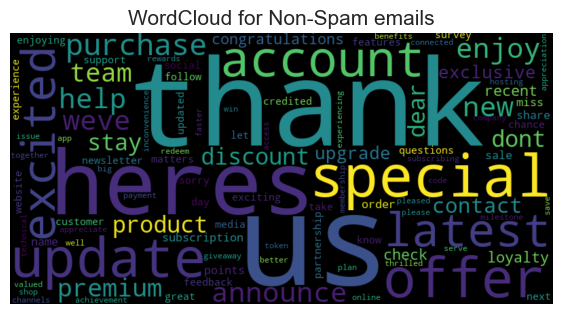

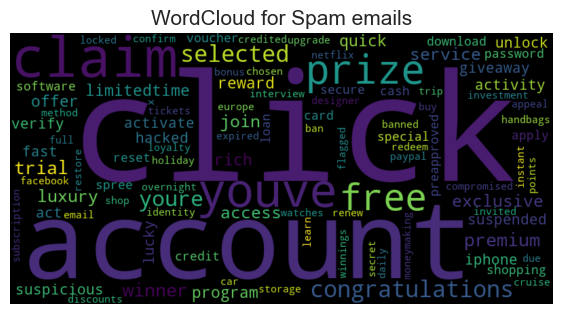

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot a word cloud
def plot_word_cloud(data, typ):
    # Combine all email text into one string
    email_corpus = " ".join(data['email'])

    # Set up the WordCloud object
    wc = WordCloud(
        background_color='black',
        max_words=100,
        width=800,
        height=400,
        collocations=False
    ).generate(email_corpus)

    # Plot the word cloud
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

# Plot word clouds for non-spam and spam emails
plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')


In [20]:
from sklearn.model_selection import train_test_split

# Converting labels to numerical values
balanced_data['label_numeric'] = balanced_data['label'].map({'ham': 0, 'spam': 1})

# Train-test split
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['email'],  # Text data
    balanced_data['label_numeric'],  # Numerical labels
    test_size=0.2,  # 20% test size
    random_state=42  # Ensure reproducibility
)

# Display the shapes of the splits
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape


((126,), (32,), (126,), (32,))

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize and fit the tokenizer on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(
    train_sequences,
    maxlen=max_len,
    padding='post',
    truncating='post'
)
test_sequences = pad_sequences(
    test_sequences,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

# Display shapes of the resulting datasets
train_sequences.shape, test_sequences.shape


((126, 100), (32, 100))

In [22]:
import tensorflow as tf

# Build the model
model = tf.keras.models.Sequential()

# Embedding layer: Converts word indices to dense vectors
model.add(tf.keras.layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,  # Vocabulary size
    output_dim=32,  # Size of the embedding vector
    input_length=max_len  # Input sequence length
))

# LSTM layer: Captures sequential dependencies
model.add(tf.keras.layers.LSTM(16))

# Fully connected layer
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Output layer: Binary classification
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # Match sigmoid activation
    metrics=['accuracy'],  # Evaluate accuracy during training
    optimizer='adam'  # Adam optimizer for efficient gradient updates
)


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback: Stops training when validation accuracy does not improve
es = EarlyStopping(
    patience=3,  # Number of epochs with no improvement to wait before stopping
    monitor='val_accuracy',  # Metric to monitor
    restore_best_weights=True  # Restore the model's best weights
)

# Reduce learning rate callback: Reduces learning rate when validation loss plateaus
lr = ReduceLROnPlateau(
    patience=2,  # Number of epochs to wait for improvement
    monitor='val_loss',  # Metric to monitor
    factor=0.5,  # Factor by which to reduce the learning rate
    verbose=0  # Suppresses the output
)


In [25]:
# Train the model with validation and callbacks
history = model.fit(
    train_sequences,  # Training data (tokenized and padded sequences)
    train_Y,  # Training labels (binary labels: ham=0, spam=1)
    validation_data=(test_sequences, test_Y),  # Validation data and labels
    epochs=20,  # Number of epochs to train the model
    batch_size=32,  # Batch size for training
    callbacks=[lr, es]  # List of callbacks for early stopping and learning rate reduction
)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4215 - loss: 0.6945 - val_accuracy: 0.5312 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4181 - loss: 0.6936 - val_accuracy: 0.4688 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5230 - loss: 0.6929 - val_accuracy: 0.4688 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5438 - loss: 0.6926 - val_accuracy: 0.4688 - val_loss: 0.6937 - learning_rate: 5.0000e-04


In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)

# Print the test results
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5312 - loss: 0.6930
Test Loss: 0.6929714679718018
Test Accuracy: 0.53125


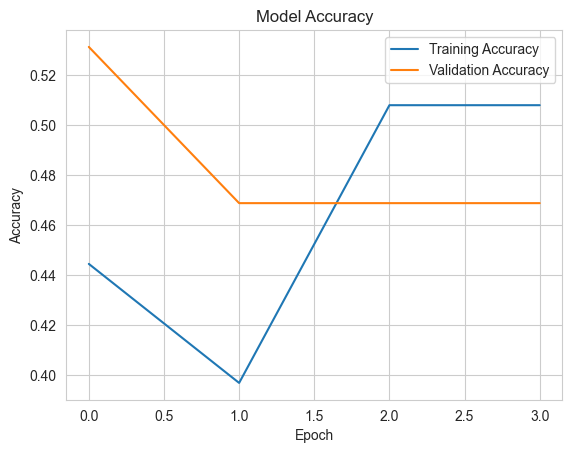

In [27]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
